In [1]:
from scikits.cuda import fft
import numpy as np

import pyfftw

from pycuda.autoinit import context
from pycuda import gpuarray
from pycuda import cumath
from pycuda import curandom

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nx = 16
ny = 32
nz = 64

In [2]:
nx = 256
ny = 256
nz = 256

In [4]:
a3d = curandom.rand((nz, ny, nx), dtype=np.float64) * 0. + 1

In [5]:
z, y, x = map(gpuarray.to_gpu, 
              np.meshgrid(np.arange(a3d.shape[0], dtype=np.float64), 
                          np.arange(a3d.shape[1], dtype=np.float64), 
                          np.arange(a3d.shape[2], dtype=np.float64), 
                          indexing='ij')
              )

In [6]:
a3d *= cumath.sin(3*x) * cumath.sin(2*y) * cumath.sin(1*z)

<matplotlib.colorbar.Colorbar instance at 0x7f6739629680>

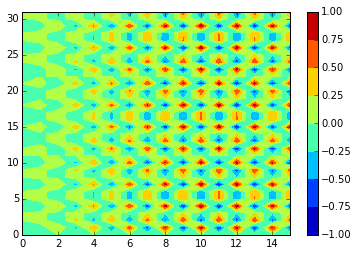

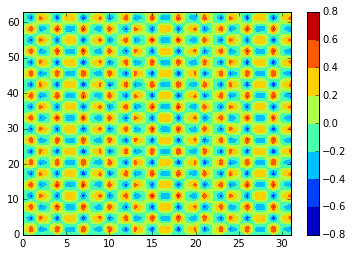

In [7]:
plt.contourf(a3d.get()[5])
plt.colorbar()

plt.figure()
plt.contourf(a3d.get()[:,:,5])
plt.colorbar()

In [9]:
plan = fft.Plan(shape=a3d.shape, in_dtype=np.complex128, out_dtype=np.complex128)

In [10]:
res = gpuarray.zeros(shape=a3d.shape, dtype=np.complex128) - 42

In [11]:
%%timeit
fft.fft(a3d.astype(np.complex128), res, plan)

The slowest run took 1312.40 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 152 µs per loop


<matplotlib.colorbar.Colorbar instance at 0x7f674406a4d0>

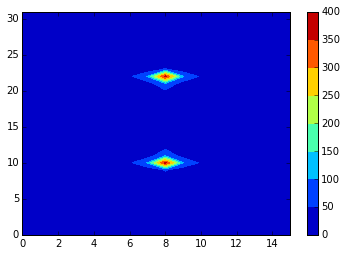

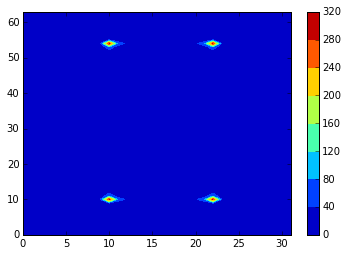

In [12]:
plt.contourf(np.abs(res.get()[8]))
plt.colorbar()

plt.figure()
plt.contourf(np.abs(res.get()[:,:,4]))
plt.colorbar()

In [13]:
a3d_h = a3d.get()

In [14]:
%%timeit
np.fft.fftn(a3d_h, a3d.shape)

100 loops, best of 3: 4.6 ms per loop


In [16]:
1.81/0.0276

65.57971014492755

<matplotlib.colorbar.Colorbar instance at 0x7f6739289ea8>

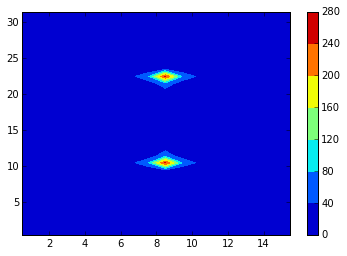

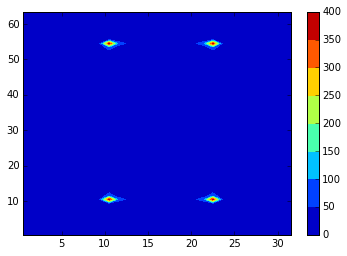

In [15]:
np_res = np.fft.fftn(a3d.get(), a3d.shape)

plt.contourf(np.abs(np_res[15]), origin='lower')
plt.colorbar()

plt.figure()
plt.contourf(np.abs(np_res[:,:,11]), origin='lower')
plt.colorbar()

In [16]:
np_res = np.fft.fftn(a3d.get(), a3d.shape)
np.allclose(res.get(), np_res)

True

In [17]:
fftw_res = pyfftw.interfaces.numpy_fft.fftn(a3d_h, a3d_h.shape)

In [18]:
np.allclose(np_res, fftw_res)

True

In [19]:
%%timeit
pyfftw.interfaces.numpy_fft.fftn(a3d_h, a3d_h.shape)

1000 loops, best of 3: 592 µs per loop


In [21]:
990/27.6

35.869565217391305

### batched 1D mode in 3 separate goes does not work! 
(need work-around for maximum of 2^{27} entries in plan for 3D with 8x Hockney algorithm in double)

http://stackoverflow.com/questions/26918101/1d-ffts-of-columns-and-rows-of-a-3d-matrix-in-cuda

### however, the following method might work for a work-around:

- batch 2D x-y FFTs until plan is full, then launch next batch of x-y FFTs
- launch len(y) many batches with length len(x) each of 1D z FFTs 
- check that transposing is not quicker for memory alignment for the last operation?

# 2D

In [171]:
a2d = a3d[1].astype(np.complex128)

In [22]:
nx = 32#1024#*4
ny = 16#1024#*4

In [23]:
a2d = gpuarray.zeros((ny, nx), dtype=np.complex128) + 1

In [24]:
y, x = map(gpuarray.to_gpu, 
           np.meshgrid(np.arange(a2d.shape[0], dtype=np.float64), 
                       np.arange(a2d.shape[1], dtype=np.float64))
              )
a2d *= cumath.sin(2*x) * cumath.sin(y)

<matplotlib.colorbar.Colorbar instance at 0x7f0787af4c68>

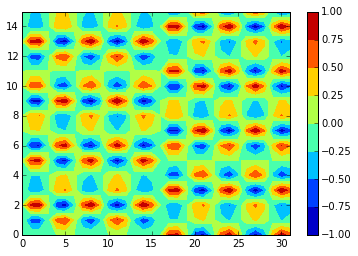

In [7]:
plt.contourf(np.real(a2d.get()))
plt.colorbar()

In [8]:
plan2d = fft.Plan(shape=a2d.shape, in_dtype=np.complex128, out_dtype=np.complex128)

In [9]:
res = gpuarray.empty(a2d.shape, dtype=np.complex128) - 42.

In [10]:
%%timeit
fft.fft(a2d, res, plan2d)

The slowest run took 13.93 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 32.6 µs per loop


<matplotlib.colorbar.Colorbar instance at 0x7f0787946830>

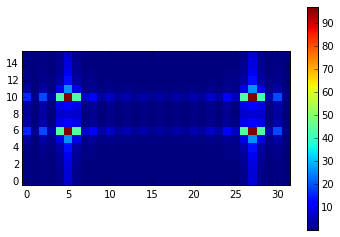

In [11]:
plt.imshow(np.abs(res.get()), interpolation='none', origin='lower')
plt.colorbar()

##FFT along x direction (first)

In [29]:
plan_1 = fft.Plan(shape=a2d.shape[1], in_dtype=np.complex128, 
                   out_dtype=np.complex128, batch=a2d.shape[0],
                   inembed=np.asarray(a2d.shape), onembed=np.asarray(a2d.shape),
                   istride=1, idist=a2d.shape[1], 
                   ostride=1, odist=a2d.shape[1])

In [30]:
res = gpuarray.empty(a2d.shape, dtype=np.complex128) - 42.

In [31]:
%%timeit
fft.fft(a2d, res, plan_1)
context.synchronize()

10000 loops, best of 3: 30.5 µs per loop


<matplotlib.colorbar.Colorbar instance at 0x7f07870bb9e0>

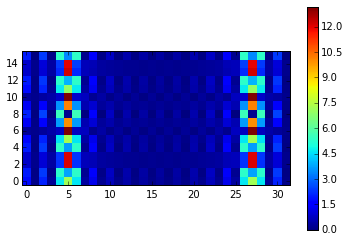

In [32]:
plt.imshow(np.abs(res.get()), interpolation='none', origin='lower')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f07869fef80>

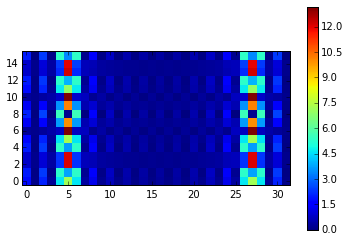

In [37]:
np_res = np.fft.fft(a2d.get(), axis=1)
plt.imshow(np.abs(np_res), interpolation='none', origin='lower')
plt.colorbar()

## alternative first FFT along y direction

<matplotlib.colorbar.Colorbar instance at 0x7f62b4e003f8>

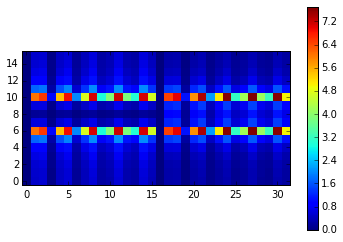

In [27]:
plan_1a = fft.Plan(shape=a2d.shape[0], in_dtype=np.complex128, 
                   out_dtype=np.complex128, batch=a2d.shape[1],
                   inembed=np.asarray(a2d.shape), onembed=np.asarray(a2d.shape),
                   istride=a2d.shape[1], idist=1, 
                   ostride=a2d.shape[1], odist=1)
resa = gpuarray.empty(a2d.shape, dtype=np.complex128) - 42.
fft.fft(a2d, resa, plan_1a)

plt.imshow(np.abs(resa.get()), interpolation='none', origin='lower')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f62b4f70bd8>

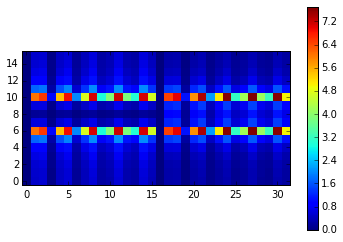

In [25]:
np_res = np.fft.fft(a2d.get(), axis=0)
plt.imshow(np.abs(np_res), interpolation='none', origin='lower')
plt.colorbar()

In [17]:
np.allclose(np_res, res.get())

True

## FFT along y direction

In [25]:
plan_2 = fft.Plan(shape=a2d.shape[0], in_dtype=np.complex128, 
                  out_dtype=np.complex128, batch=a2d.shape[1],
                  inembed=np.asarray(a2d.shape), onembed=np.asarray(a2d.shape),
                  idist=1, istride=a2d.shape[1], 
                  odist=1, ostride=a2d.shape[1])

In [26]:
res2 = gpuarray.empty(a2d.shape, dtype=np.complex128) - 42.

In [27]:
%%timeit
fft.fft(res, res2, plan_2)

The slowest run took 7.36 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 25 µs per loop


<matplotlib.colorbar.Colorbar instance at 0x7f0787253518>

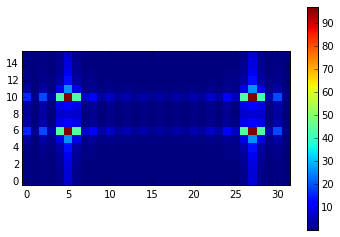

In [28]:
plt.imshow(np.abs(res2.get()), interpolation='none', origin='lower')
plt.colorbar()

In [22]:
a2d_h = a2d.get()

In [23]:
%%timeit
np.fft.fft2(a2d_h)

The slowest run took 7.82 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 106 µs per loop


<matplotlib.colorbar.Colorbar instance at 0x7f07873e61b8>

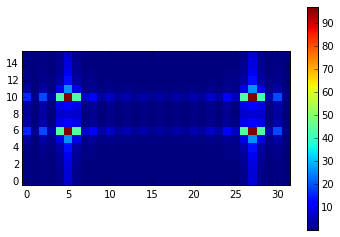

In [24]:
np_res = np.fft.fft2(a2d.get())
plt.imshow(np.abs(np_res), interpolation='none', origin='lower')
plt.colorbar()

In [71]:
np.allclose(res2.get(), np_res)

True

In [79]:
fftw_1 = pyfftw.builders.fft(a2d_h, axis=0)
fftw_2 = pyfftw.builders.fft(a2d_h, axis=1)

In [80]:
%%timeit
fftw_res = fftw_1(a2d_h)
fftw_res = fftw_2(fftw_res)

10 loops, best of 3: 27.9 ms per loop


In [62]:
fftw_res = fftw(a2d.get())

In [63]:
np.allclose(fftw_res, np_res)

False

In [76]:
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(30)

In [77]:
%%timeit
pyfftw.interfaces.numpy_fft.fft2(a2d_h)

10 loops, best of 3: 25.1 ms per loop


In [22]:
25.1/1.17

21.452991452991455

# 1D

In [65]:
a1d = a3d[1,1].astype(np.complex128)

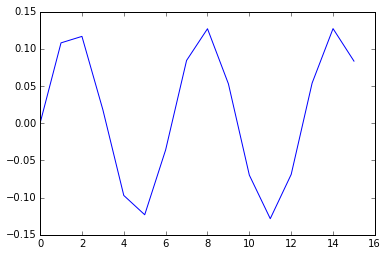

In [68]:
plt.plot(np.real(a1d.get()))

In [69]:
plan = fft.Plan(shape=a1d.shape, in_dtype=np.complex128, out_dtype=np.complex128)

In [70]:
res = gpuarray.zeros(a1d.shape, dtype=np.complex128) - 42.

In [71]:
fft.fft(a1d, res, plan)

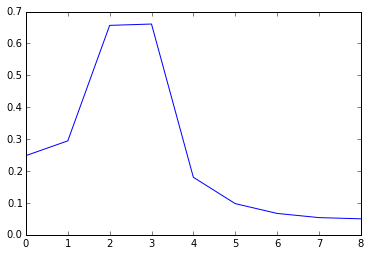

In [72]:
plt.plot(np.abs(res.get())[:(a1d.shape[0]/2 + 1)])

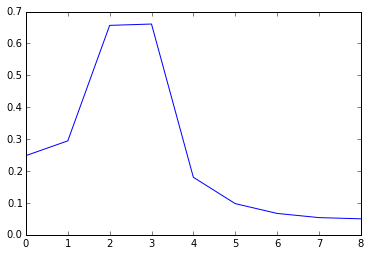

In [73]:
plt.plot(np.abs(np.fft.fft(a1d.get()))[:(a1d.shape[0]/2 + 1)])